<header>
    <h1>CA4010 - Data warehousing and Data mining</h1>
    <h2>Continuous assessment project</h2>
</header>
<p>
    For this project, we want to predict if a project submitted to 
    <a href="https://www.indiegogo.com">indiegogo.com</a> will or will not be funded.
    For this purpose, we'll use a
    <a href="https://www.kaggle.com/kingburrito666/indiegogo-project-statistics/data">
    dataset from kaggle containing one year of indiegogo projects.</a>
    The version used here is the concatenation of all csv files using the given 'combiner.py'.<br/>
    However, some modifications has been made from combiner.py:
    <ul>
        <li>
            One row was normalized : <i>in_forever_funding</i> was passed to 'True' instead of 'null' to avoid
            type warning at loading time and use boolean type for this attribute.
        </li>
        <li>
            The file was saved as tsv (tab separated values) instead of csv for a better readability.
        </li>
    </ul>
</p>
<p>
    This notebook will decribe and show what data visualisation had learned to us about our dataset.
</p>

<h2>Analyze of the continuous attributes</h2>
<p>
    In this part, we'll analyze of the continuous attibutes of our dataset:
        <ul>
            <li><b>collected_percentage</b>: Which is the percentage of fund collected at the end of the project</li>
            <li><b>target_amount</b>: which is the USD value of the fund requested</li>
            <li><b>pledges_count</b>: which is the number of crowdfunders</li>
            <li><b>tagline_len</b>: the number of characters in the tagline</li>
            <li><b>title_len</b>: the number of characters in the title</li>
        </ul>
</p>

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
indiegogo = pd.read_csv('indiegogo_cleaned_dataset_500.tsv', sep='\t')

<p>First, we'll look for collected_percentage, target_amount
and pledges_count correlation. We expect that the <b>number of crowdfunders</b> (pledges_count) is strongly correlated with the <b>collected_percentage</b> as we assume that the more people are giving money to a project, the more its chances to succeed increase. We also suspect that the bigger the target_amount is, the less the collected percentage will tend to have very huge values.</p>

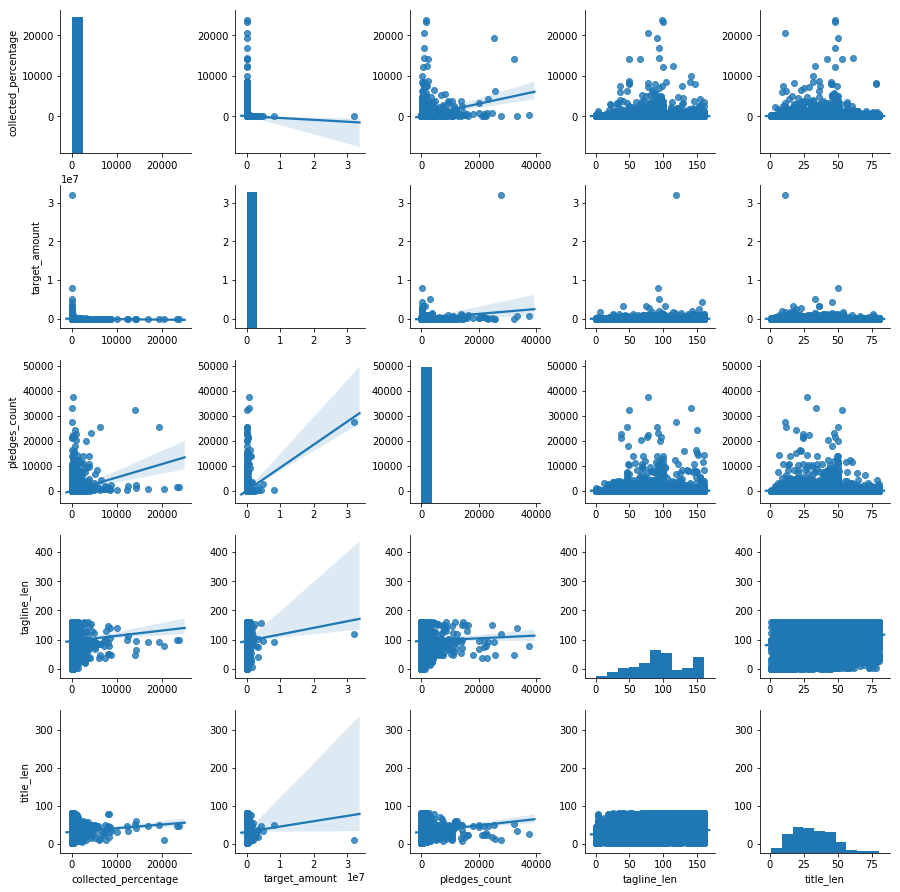

In [13]:
g = sns.PairGrid(indiegogo[["collected_percentage", "target_amount", "pledges_count", "tagline_len", "title_len"]])
g.map_offdiag(sns.regplot) 
g.map_diag(plt.hist) 

<p>With the processed graph we can notice several things:
    <ul>
        <li>The great majority of projects have low values for these attributes and only some of them are very high values. We must check if these projects are outliers or only another type of project which can't be compared to those with lower values.</li>
        <li>The projects with the higher collected percentage are generaly those with the lowest target_amount</li>
        <li>Some projects asks for a huge amount of money (5 to 10 milllions !)</li>
        <li>Surprisngly enough, some projects seems to reach a high collected percentage with very few pledges. This can be due to a very low goal amount.</li>
        <li>pledges_count and collected_percentages are not as closely related as we supposed because the collected_percentage also greately depends on the target_amount. The 3 values are all linked.</li>
        <li>tagline_len anf title_len doesn't seems to be correlated with the succes of a project</li>
    </ul>
  We can see that these 3 attributes are closely related to each other and seems to influence each other greatly. To see it with more detail, it could be interesting to plot a 3D graph of these 3 attributes. 
</p>

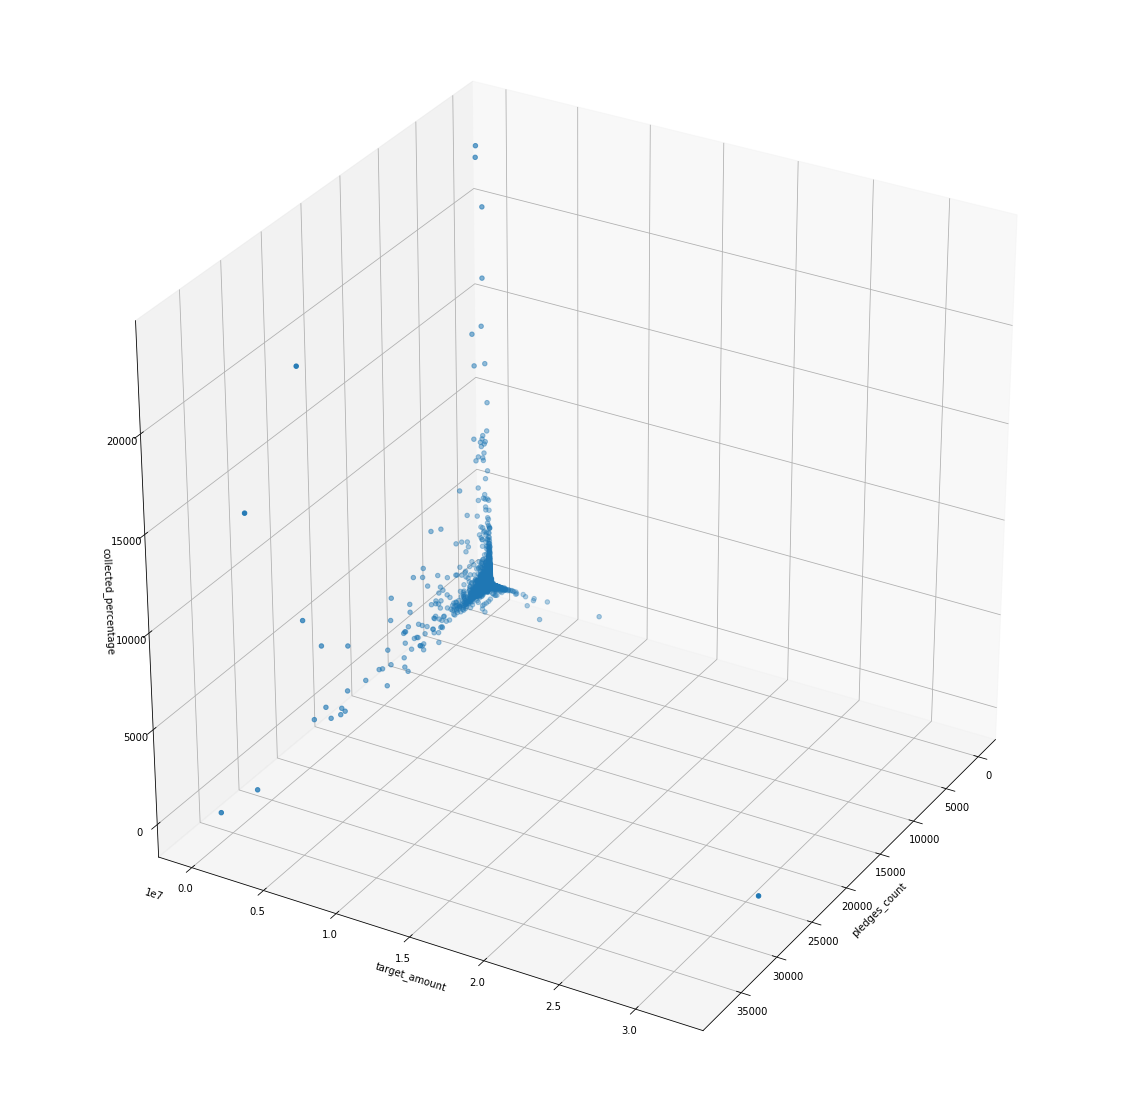

In [4]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.set_ylabel('target_amount')
ax.set_zlabel('collected_percentage')
ax.set_xlabel('pledges_count')
ax.scatter(indiegogo['pledges_count'].values, indiegogo['target_amount'].values,
          indiegogo['collected_percentage'].values)

ax.view_init(30, 30)

<p>Our first hinch was correct: most of the very high collected percentages with very low pledges count are linked to a low target_amount. In fact very high collected percentages occurs always when the target_amount is low. Is it due to crowdfunding projects at 1$ goal ? Let's have a closer look to the projects with low target_amount and high collected percentage.
</p>

In [5]:
indiegogo[indiegogo.collected_percentage > 10000]

,title_len,tagline_len,pledges_count,currency_code,category_slug,collected_percentage,has_partner,target_amount
13315,53,49,32251,USD,local_businesses,14063.0,False,5000.127995
24393,42,65,2261,USD,film,14236.0,False,1065.243046
49401,50,91,25378,USD,travel_outdoors,19395.0,True,21271.162671
49467,48,98,1516,USD,health,23788.0,False,1444.703212
49500,48,100,1564,USD,phones_accessories,23209.0,False,1000.000000
49531,48,93,797,USD,phones_accessories,16757.0,False,1019.018917
49664,48,100,521,USD,phones_accessories,12165.0,False,1134.656802
49719,11,78,716,USD,phones_accessories,20434.0,False,500.004894
49783,61,94,977,USD,fashion,14282.0,False,499.992998
52362,32,141,260,USD,local_businesses,10005.0,False,1000.009995


In [6]:
indiegogo.target_amount.min()

300.0

<p>Surprisingly not. The lowest target_amount is <b>62000 USD</b> ! which is not even close to the min value of <b>300 USD</b>. Some projects seems to have few but very generous crowdfunders.</p>

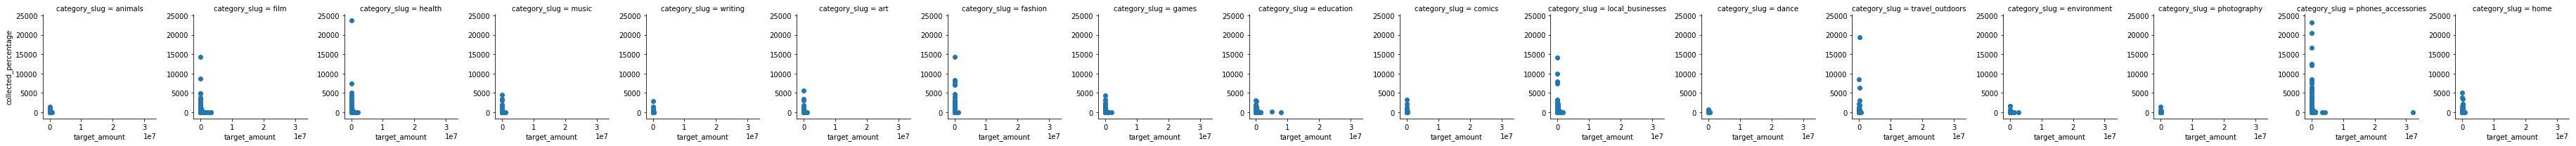

In [7]:
g = sns.FacetGrid(indiegogo, col="category_slug") 
g.map(plt.scatter, "target_amount", "collected_percentage")

<h2>Analyze of the discrete attributes</h2>
<p>
    In this part, we'll analyze of the discrete attibutes of our dataset:
        <ul>
            <li><b>category_slug</b>: Which are the categories of the projects</li>
            <li><b>has_partner</b>: true if the project has a partner, false otherwise</li>
            <li><b>currency_code</b>: which is the original currency code and can give us an overview of projects origins</li>
        </ul>
</p>

<p>First we'll look at the number of projects by categories</p>

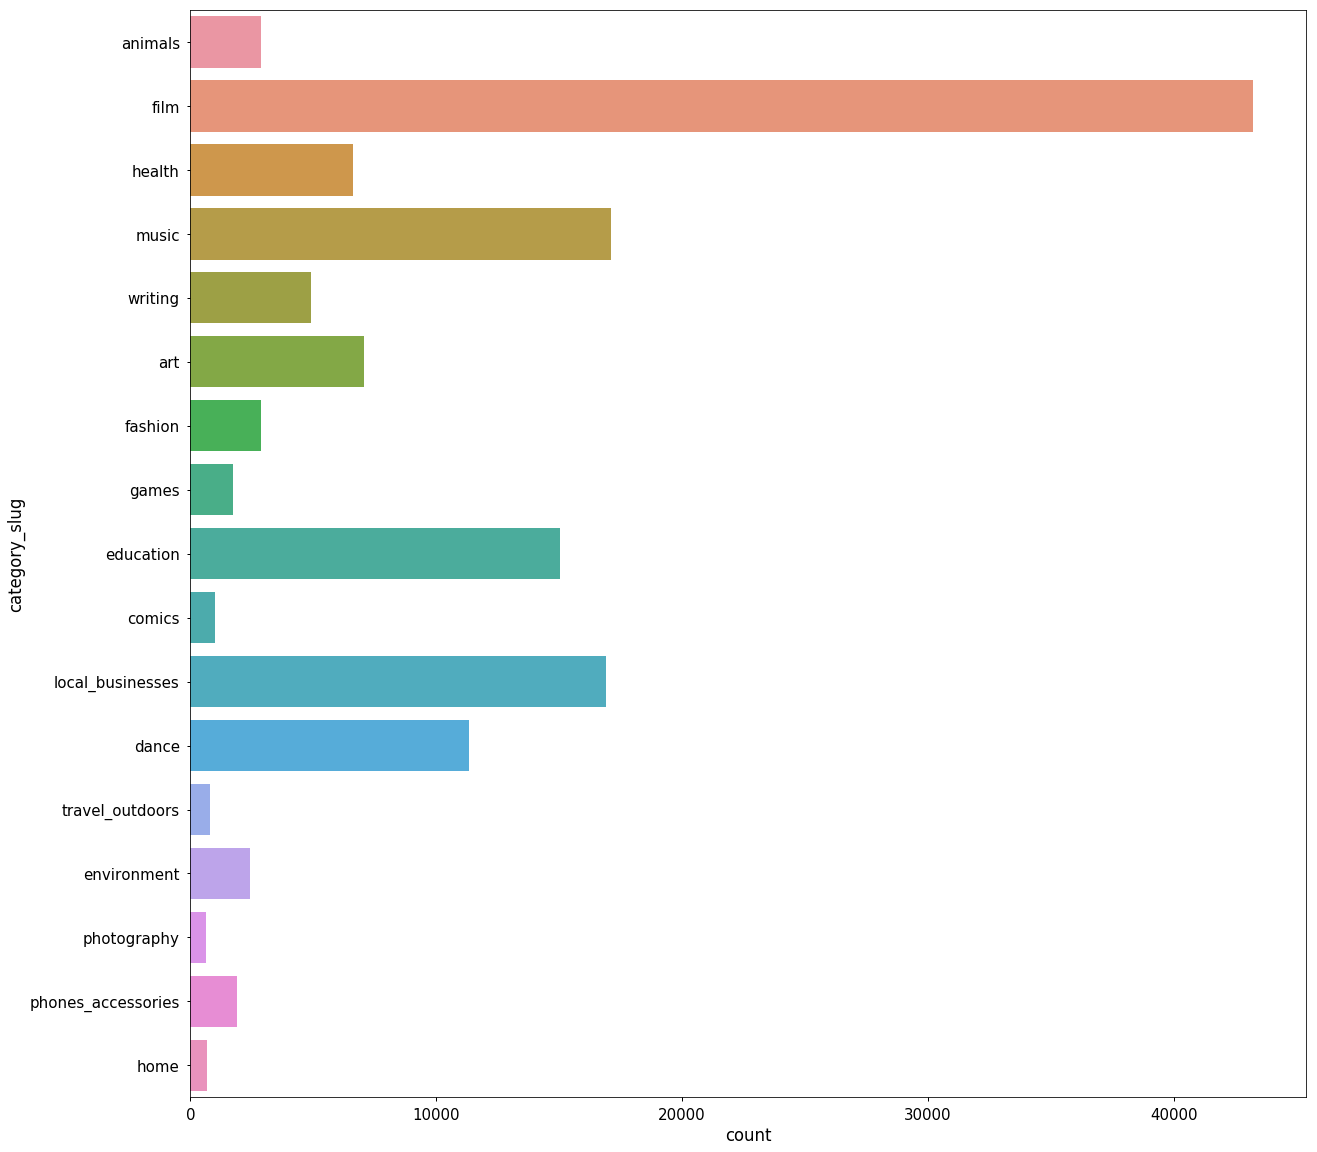

In [10]:
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(20, 20))
    sns.countplot(y="category_slug", data=indiegogo)

<p>We can see that film is the most popular category with more than 40000 projects. This is twice more than the second most popular project ! The second and third ones are music and local_businesses with about 2000 projects each.</p>

<p>Let's detail the pledge_count, collected_percentage and targe_amount of each categories</p>

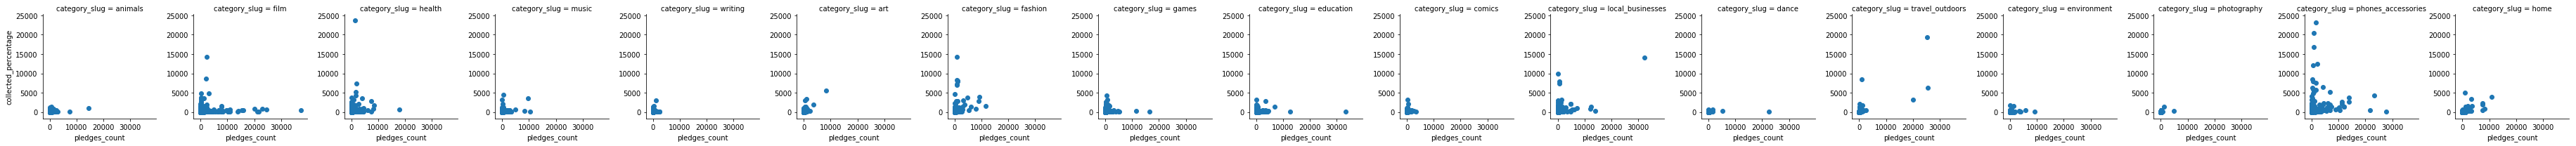

In [8]:
g = sns.FacetGrid(indiegogo, col="category_slug") 
g.map(plt.scatter, "pledges_count", "collected_percentage")

<p>
    We can see here too that film category is very popular as this is the category containing the higher pledges counts. Fashion projects tends to be popular with high pledges count and high collected percentages.Phone accessories are amazingly populares and have the higher collected percentages as well as a good rate of high pledges count, but not on the same projects.
</p>

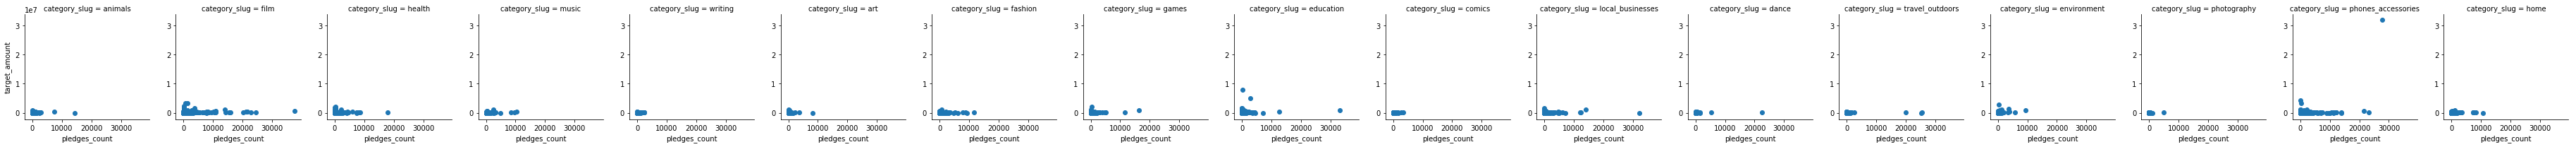

In [18]:
g = sns.FacetGrid(indiegogo, col="category_slug") 
g.map(plt.scatter, "pledges_count", "target_amount")

In [16]:
indiegogo[indiegogo.target_amount > 10000000]

,title_len,tagline_len,pledges_count,currency_code,category_slug,collected_percentage,has_partner,target_amount
136166,11,119,27635,USD,phones_accessories,40.0,True,32035540.0


<p>We can notie that most of the categories has targetsproject amounts below 2 500 000 USD, and that in most of the cases, people are less interested in funding projects with high target amount. We can also see that a project in phone accessories was very popular and ask for more than 32 millions USD ! (after searching it in the dataset it was a crowdfunding for Ubuntu Edge).</p>

<p>Now, let's analyze the partners. We are expecting to see that a partner is increasing the pleges count and the collected percentage. Let's see our hinch is verified.</p>

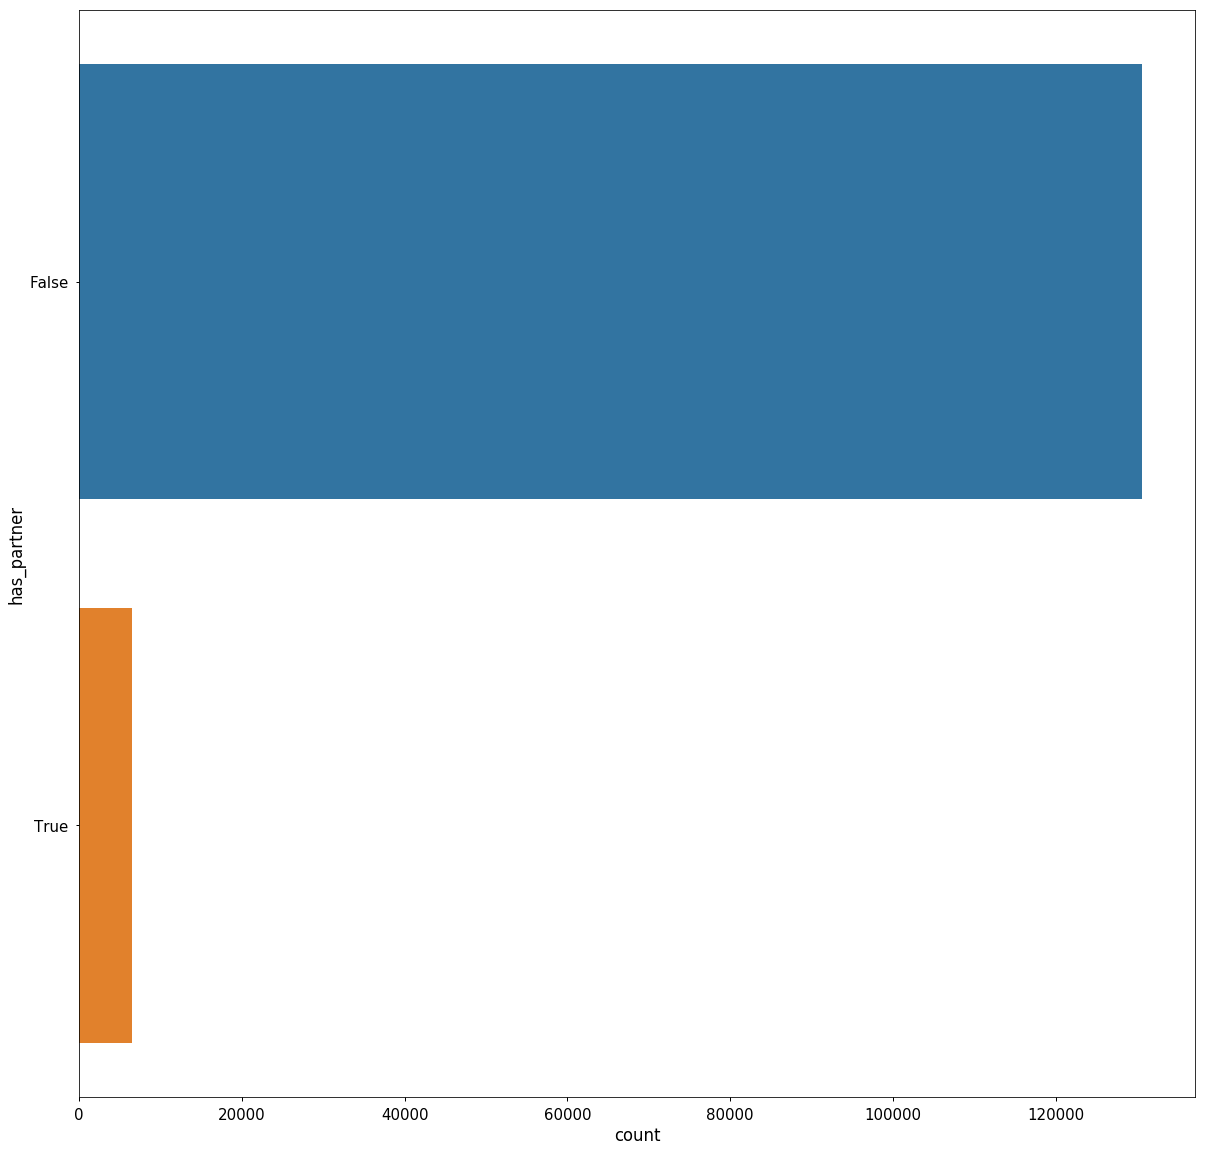

In [28]:
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(20, 20))
    sns.countplot(y="has_partner", data=indiegogo)

<p>Only few projects, 4.7% in fact, have a partnership, this make very uncertain the assumptions and analyzes done based on the criterion as we don't have a great number of partnership projects to detail.</p>

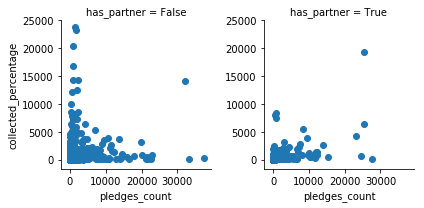

In [25]:
g = sns.FacetGrid(indiegogo, col="has_partner") 
g.map(plt.scatter, "pledges_count", "collected_percentage")

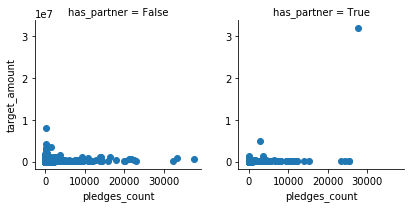

In [26]:
g = sns.FacetGrid(indiegogo, col="has_partner") 
g.map(plt.scatter, "pledges_count", "target_amount")

<p>We can notice that the pledges and amount required doesn't seems to change very much with a partner (we can still notice the Ubuntu project in the second graph). In fact the very high collected percentages with few, generous crowdfunders we've seen in the first part of the analyze doesn't have partnership. Partnership doesn't seems to influence the succes of a project, which is very surprising.</p>

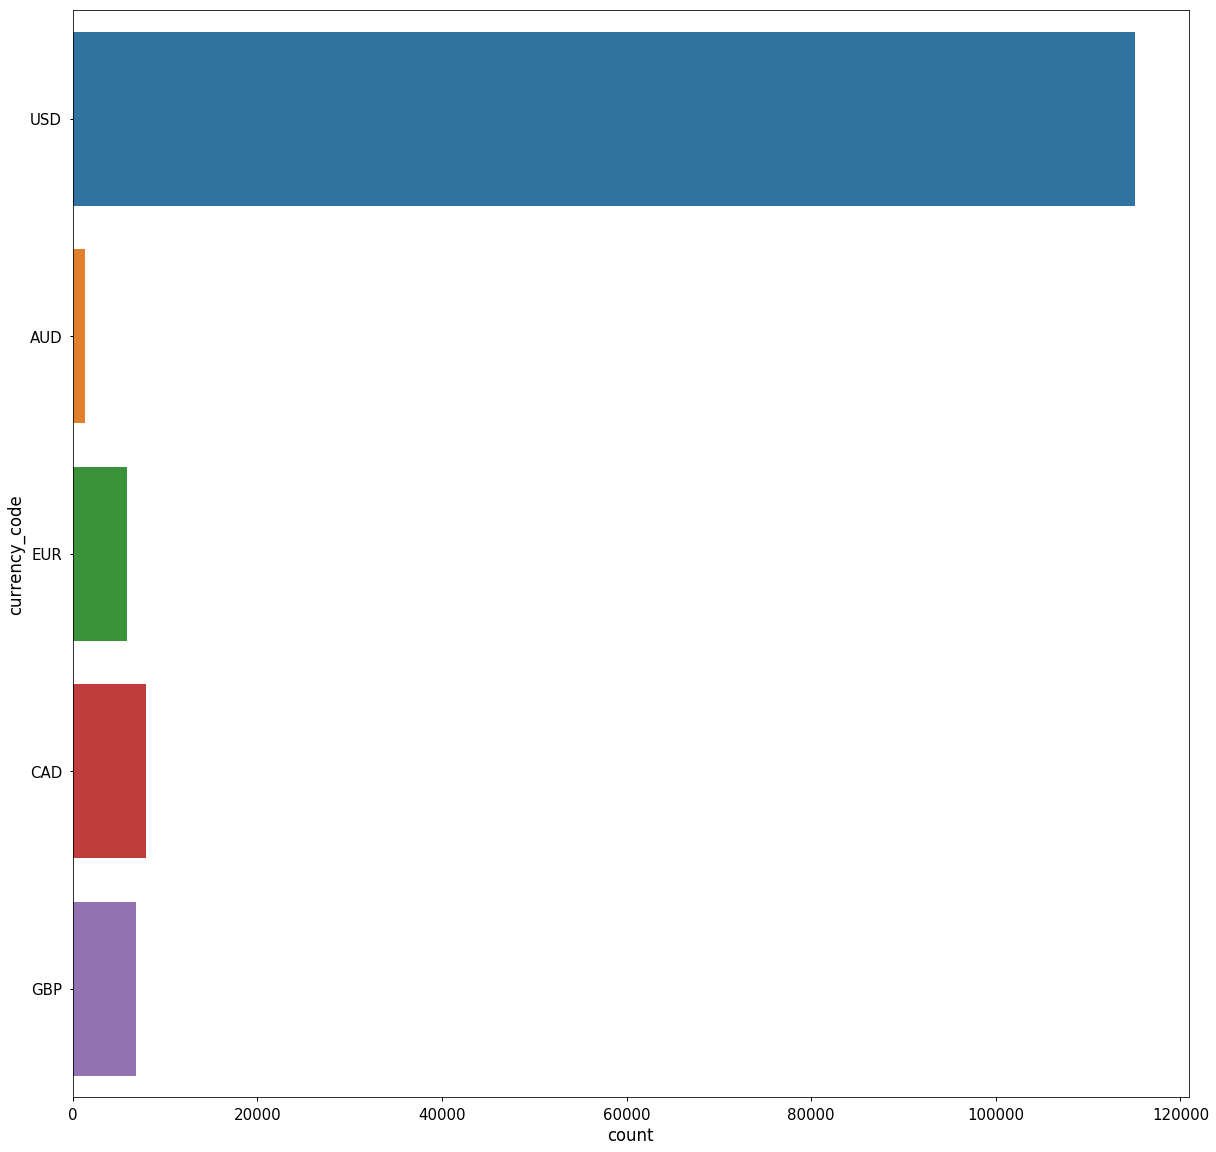

In [31]:
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(20, 20))
    sns.countplot(y="currency_code", data=indiegogo)

<p>Most of the projects seems to be from the USA, or done by people who wanted to have visibility in the USA.</p>